# 示例代码

一些实际中碰到的例子。

1. shapefile坐标转换
2. 点shape和面shape的空间连接
3. shapefile的裁剪
4. 计算点的空间分布离散度

## 例1

首先是一个shapefile有多个polygon组成，每个polygon代表一个流域，对每个polygon做坐标变换。

examples_data\bas_nonref_CntlPlains.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
           AREA  PERIMETER   GAGE_ID  \
0  1.209580e+08    81060.0  03144816   
1  3.458990e+08   158340.0  03145000   
2  2.573460e+07    38760.0  03156000   
3  2.288740e+08   115800.0  03157000   
4  1.194710e+09   290820.0  03157500   

                                            geometry  
0  POLYGON ((1123005.000 1972005.000, 1123035.000...  
1  POLYGON ((1123005.000 1972005.000, 1123035.000...  
2  POLYGON ((1130325.000 1933275.000, 1130325.000...  
3  POLYGON ((1123755.000 1919955.000, 1123725.000...  
4  POLYGON ((1123755.000 1919955.000, 1123725.000...  
Index(['AREA', 'PERIMETER', 'GAGE_ID', 'geometry'], dtype='object')


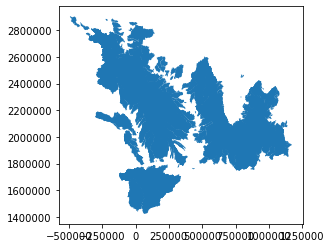

In [19]:
import os
import geopandas as gpd

# Define path to folder，以r开头表示相对路径
input_folder = r"examples_data"

# Join folder path and filename
fp = os.path.join(input_folder, "bas_nonref_CntlPlains.shp")

# Print out the full file path
print(fp)

# Read file using gpd.read_file()
data = gpd.read_file(fp)

print(type(data))
# 注意观察，geometry是一个由一系列坐标点组成的list，放入polygon的
print(data.head())
print(data.columns)

%matplotlib inline
data.plot()

先做坐标转换，首先看看现有数据的坐标系是什么，从上面的数据可以看出，坐标应该是m的形式，肯定是个投影坐标系。

In [25]:
from pyproj import CRS
print(data.crs)
# crs_proj4 = CRS(data.crs).to_proj4()
# print(crs_proj4)

{'proj': 'aea', 'lat_0': 23, 'lon_0': -96, 'lat_1': 29.5, 'lat_2': 45.5, 'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}


epsg:5070代表什么呢？在[epsg网站](https://epsg.io/)上查询，或直接谷歌或百度搜索。经查，在 https://epsg.io/5070-1252 网页上有说明，那现在想把它转为什么坐标呢，想转为下面要用的netcdf数据的坐标，因此这里暂停下，去下面看看netcdf数据的读取。然后查看下netcdf数据的坐标信息，这里先用一个[nad83下的Lambert等角圆锥投影](https://epsg.io/102009)到一个[wgs84下的横轴墨卡托投影](https://epsg.io/41001)的坐标变换做例子，为了验证是否正确，在https://epsg.io/ 网站上转一个点，然后和这里对照。

![](trans_coord.png)

In [28]:
from pyproj import Transformer
from pyproj import CRS, Proj, transform
import time

crs_from=CRS.from_proj4('+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
crs_to=CRS.from_proj4('+proj=merc +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
print(crs_from)
print(crs_to)
# print(crs_to.to_epsg())
# 定义transformer
transformer = Transformer.from_crs(crs_from, crs_to, always_xy=True)
x_coord = 1427469.56401013
y_coord = 231871.42687957
start=time.time()
x1,y1 = transformer.transform(x_coord, y_coord)  
end=time.time()
print(x1)
print(y1)
print('%.7f' % (end-start))

#  接着转换x，y坐标为经纬度坐标 WGS84坐标
# outProj = Proj('epsg:4326')
# python3.7 下 定义proj的方式如下所示。更多内容可以参考：https://pyproj4.github.io/pyproj/stable/index.html
outProj = CRS.from_epsg(4326)
print(outProj)
x2,y2 = transform(crs_to,outProj,x1,y1)
print(x2)
print(y2)

+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs
+proj=merc +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
-8667612.35367563
4954170.578414324
0.0000000
epsg:4326
40.79460979159966
-77.86248654129997


![](trans_coord1.png)

下面例子中netcdf数据的坐标proj4信息是：+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs

因此，将shapefile文件的坐标转换到该坐标下即可继续后面的运算。先尝试下转换到该坐标系下的情况，然后再转到WGS84下看看对错。坐标是一样的，应该是对的

In [29]:
crs_final=CRS.from_proj4('+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
print(crs_final)
# 这应该是自定义的一种投影，没有epsg编号
print(crs_final.to_epsg())
transformer1 = Transformer.from_crs(crs_from, crs_final, always_xy=True)
x3,y3 = transformer1.transform(x_coord, y_coord)  
print(x3)
print(y3)
lon,lat = transform(crs_final,outProj,x3,y3)
print(lon)
print(lat)

# 再试一些点
x4= -4560250
y4= 4984000                         # 3090000
lon4,lat4 = transform(crs_final,outProj,x4,y4)
print(lon4,lat4)
x5= -4560250                 # 3252750
y5=  4983000                # 4984000
lon5,lat5 = transform(crs_final,outProj,x5,y5)
print(lon5,lat5)

+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
None
1762267.535784329
54546.4057676215
40.79460979159966
-77.86248654129997
58.527701348497665 156.37123798357752
58.52477921360861 156.38762505680887


再从经纬度转回投影坐标

In [30]:
y,x = transform(outProj,crs_final, lon,lat)
print(y,x)

1762267.5357843342 54546.40576760309


如果是shapefile，那么直接一个个地转换坐标是很慢的，所以看看能不能直接转换shapefile，找到了一个利用pandas dataframe的算法。以下代码参考：https://gis.stackexchange.com/a/327367/154364

In [31]:
import pandas as pd
from pyproj import Proj, transform
from pyproj import Transformer
import time
from pyproj import CRS

crs_from=CRS.from_proj4('+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
outProj = CRS.from_epsg(4326)
df = pd.DataFrame({'x': [1427469.56401013]*100000, 
                   'y': [231871.42687957]*100000})
print(type(df['x']))
start=time.time()
df['x2'], df['y2'] = transform(crs_from, outProj, df['x'].tolist(), df['y'].tolist())
end=time.time()
print('%.7f' % (end-start))
print(df['x2'])
print(df['y2'])

<class 'pandas.core.series.Series'>
0.2178726
0        40.79461
1        40.79461
2        40.79461
3        40.79461
4        40.79461
           ...   
99995    40.79461
99996    40.79461
99997    40.79461
99998    40.79461
99999    40.79461
Name: x2, Length: 100000, dtype: float64
0       -77.862487
1       -77.862487
2       -77.862487
3       -77.862487
4       -77.862487
           ...    
99995   -77.862487
99996   -77.862487
99997   -77.862487
99998   -77.862487
99999   -77.862487
Name: y2, Length: 100000, dtype: float64


换一个坐标系再试一次：

In [33]:
# outProj_another= Proj(init='epsg:4269')
outProj_another= CRS.from_epsg(4269)
df['x3'], df['y3'] = transform(outProj_another,outProj,  df['x2'].tolist(), df['y2'].tolist())
print(df['x3'])
print(df['y3'])

0        40.79461
1        40.79461
2        40.79461
3        40.79461
4        40.79461
           ...   
99995    40.79461
99996    40.79461
99997    40.79461
99998    40.79461
99999    40.79461
Name: x3, Length: 100000, dtype: float64
0       -77.862487
1       -77.862487
2       -77.862487
3       -77.862487
4       -77.862487
           ...    
99995   -77.862487
99996   -77.862487
99997   -77.862487
99998   -77.862487
99999   -77.862487
Name: y3, Length: 100000, dtype: float64


接下来就构建一个shapefile到shapefile的代码，首先读取shapefile，然后对每个polygon的每个坐标点进行坐标变换，然后再重新构建一个个的shapefile，以备后用。

然后再将shapefile分割成多个，在实际运行中可以不必写入shapefile，只是构建为独立的geodataframe。

In [34]:
from pyproj import CRS
# 索引和dataframe一致
print('第一行',data.iloc[0,:],'\n')
print('geometry: ',type(data.iloc[0,:]['geometry']),'\n')
print('exteriors: ',list(data.iloc[0,:]['geometry'].exterior.coords)[0:5],'\n')
print('interiors',list(data.iloc[0,:]['geometry'].interiors)[0:5],'\n')
print('边界：',list(data.iloc[0,:]['geometry'].boundary)[0:5],'\n')
newdata = gpd.GeoDataFrame()
# 要赋值到0位置上，否则就成为geoseries了，如果需要将一个shpfile 拆分成多个，循环data 赋给不同的newdata，然后写入新文件即可（取消下面的注释即可），这里就只给了一个，仅作示例
newdata.at[0, 'geometry']  = data.iloc[0,:]['geometry']
print(type(newdata.at[0, 'geometry'] ))
newdata.at[0, 'AREA'] = data.iloc[0,:]['AREA']
newdata.at[0, 'PERIMETER'] = data.iloc[0,:]['PERIMETER']
newdata.at[0, 'GAGE_ID'] = data.iloc[0,:]['GAGE_ID']
print(newdata)
# Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
newdata.crs = CRS.from_epsg(4326).to_wkt()
print("\nWell-Known Text (WKT):\n",newdata.crs)
# def wirte_shpfile(selection):
#     #  每行直接索引出来的就不是Geodataframe数据了，所以要    
#     newdata = gpd.GeoDataFrame()
#     newdata['geometry'] = selection['geometry']
    
#     series.plot()
#     # Create a output path for the data
#     output_folder = r"L2_data/"
#     output_fp = os.path.join(output_folder, "Class_36200.shp")
#     # Write those rows into a new file (the default output file format is Shapefile)
#     selection.to_file(output_fp)
    
# shp_files = df.iloc[5,:].apply(wirte_shpfile, axis=1)

第一行 AREA                                               1.20958e+08
PERIMETER                                                81060
GAGE_ID                                               03144816
geometry     POLYGON ((1123005 1972005, 1123035 1972005, 11...
Name: 0, dtype: object 

geometry:  <class 'shapely.geometry.polygon.Polygon'> 

exteriors:  [(1123005.0, 1972005.0), (1123035.0, 1972005.0), (1123065.0, 1972005.0), (1123065.0, 1971975.0), (1123095.0, 1971975.0)] 

interiors [<shapely.geometry.polygon.LinearRing object at 0x0000025C78CC2F08>] 

边界： [<shapely.geometry.linestring.LineString object at 0x0000025C78CC3588>, <shapely.geometry.linestring.LineString object at 0x0000025C7B1B25C8>] 

<class 'shapely.geometry.polygon.Polygon'>
                                            geometry         AREA  PERIMETER
0  POLYGON ((1123005 1972005, 1123035 1972005, 11...  120958000.0    81060.0

Well-Known Text (WKT):
 GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",63781

## 例2

接下来一个例子是判断一个shapefile中的points都在另一个shapefile的哪些polygons中，然后要把每个polygon的编号放入在它其中的point属性中。使用的数据是GAGESII的站点shapefile和HUC4级的流域shape图。

In [4]:
import geopandas as gpd

points_file = "examples_data/gagesII_9322_sept30_2011.shp"
points = gpd.read_file(points_file)
print("Number of rows:",len(points))
points.head()

Number of rows: 9322


,STAID,STANAME,CLASS,AGGECOREGI,DRAIN_SQKM,HUC02,LAT_GAGE,LNG_GAGE,STATE,HCDN_2009,ACTIVE09,FLYRS1900,FLYRS1950,FLYRS1990,geometry
0,01011000,"Allagash River near Allagash, Maine",Non-ref,NorthEast,3186.8440,01,47.069611,-69.079544,ME,None,yes,78.0,60.0,20.0,POINT (2027371.849 2964479.789)
1,01013500,"Fish River near Fort Kent, Maine",Ref,NorthEast,2252.6960,01,47.237394,-68.582642,ME,yes,yes,85.0,60.0,20.0,POINT (2058479.303 2992966.016)
2,01015800,"Aroostook River near Masardis, Maine",Non-ref,NorthEast,2313.7550,01,46.523003,-68.371764,ME,None,yes,51.0,51.0,19.0,POINT (2096533.991 2921785.543)
3,01016500,"MACHIAS RIVER NEAR ASHLAND, ME",Non-ref,NorthEast,847.7721,01,46.628311,-68.434792,ME,None,None,32.0,32.0,0.0,POINT (2088548.849 2931578.094)
4,01017000,"Aroostook River at Washburn, Maine",Non-ref,NorthEast,4278.9070,01,46.777294,-68.157194,ME,None,yes,79.0,60.0,20.0,POINT (2104213.711 2953507.477)


In [5]:
points.crs

{'proj': 'aea',
 'lat_0': 23,
 'lon_0': -96,
 'lat_1': 29.5,
 'lat_2': 45.5,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

因为这里是把点属于哪个HUC4流域的属性加进来，很多属性也用不到，所以可以去掉一部分。

In [6]:
# Subset columns
points = points[["STAID", "STANAME",'CLASS','AGGECOREGI','DRAIN_SQKM','HUC02','LAT_GAGE','LNG_GAGE','STATE','geometry']]
points.head()

,STAID,STANAME,CLASS,AGGECOREGI,DRAIN_SQKM,HUC02,LAT_GAGE,LNG_GAGE,STATE,geometry
0,01011000,"Allagash River near Allagash, Maine",Non-ref,NorthEast,3186.8440,01,47.069611,-69.079544,ME,POINT (2027371.849 2964479.789)
1,01013500,"Fish River near Fort Kent, Maine",Ref,NorthEast,2252.6960,01,47.237394,-68.582642,ME,POINT (2058479.303 2992966.016)
2,01015800,"Aroostook River near Masardis, Maine",Non-ref,NorthEast,2313.7550,01,46.523003,-68.371764,ME,POINT (2096533.991 2921785.543)
3,01016500,"MACHIAS RIVER NEAR ASHLAND, ME",Non-ref,NorthEast,847.7721,01,46.628311,-68.434792,ME,POINT (2088548.849 2931578.094)
4,01017000,"Aroostook River at Washburn, Maine",Non-ref,NorthEast,4278.9070,01,46.777294,-68.157194,ME,POINT (2104213.711 2953507.477)


In [7]:
polygons_file = "examples_data/HUC4.shp"
polys = gpd.read_file(polygons_file)
#Check the data
print("Number of rows:",len(polys))
polys.head(5)

Number of rows: 223


,OBJECTID,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC4,NAME,SHAPE_Leng,SHAPE_Area,geometry
0,1,{2836BE66-8D09-4A23-819A-032ACFC07EC9},None,None,None,None,2012-06-11,0,44545954.0,180271.24,AK,1901,Southeast Alaska,57.947896,28.870353,"MULTIPOLYGON (((-138.05906 61.25548, -138.0569..."
1,2,{9F60218E-B1CA-4EAF-8931-CA52BDA34AB3},None,None,None,None,2012-06-11,0,65524952.0,265170.31,AK,1902,South Central Alaska,89.820883,43.854624,"MULTIPOLYGON (((-147.12113 63.62619, -147.1193..."
2,3,{385907E5-EED5-4B90-97A3-403EC8B96CF6},None,None,None,None,2012-06-11,0,81222880.0,328697.62,AK,1903,Southwest Alaska,154.283501,55.858380,"MULTIPOLYGON (((-152.03511 64.41507, -152.0325..."
3,4,{84E9AA98-74D8-49D9-BE79-A44C89A3EFCE},None,None,None,None,2012-06-11,0,50834280.0,205719.21,AK,1905,Northwest Alaska,71.800744,41.153359,"MULTIPOLYGON (((-166.16926 68.87117, -166.1683..."
4,5,{E510FB22-3CEC-4490-B6D4-1A2EF616217E},None,None,None,None,2012-06-11,0,59066087.0,239032.18,AK,1906,Arctic Alaska,74.176092,54.664269,"POLYGON ((-155.77282 71.28410, -155.77268 71.2..."


同样的，polygon的属性也不需要全部，取一部分

In [8]:
# Subset columns
polys = polys[["OBJECTID", "AREAACRES",'AREASQKM','STATES','HUC4','NAME','SHAPE_Leng','SHAPE_Area','geometry']]
polys.head()

,OBJECTID,AREAACRES,AREASQKM,STATES,HUC4,NAME,SHAPE_Leng,SHAPE_Area,geometry
0,1,44545954.0,180271.24,AK,1901,Southeast Alaska,57.947896,28.870353,"MULTIPOLYGON (((-138.05906 61.25548, -138.0569..."
1,2,65524952.0,265170.31,AK,1902,South Central Alaska,89.820883,43.854624,"MULTIPOLYGON (((-147.12113 63.62619, -147.1193..."
2,3,81222880.0,328697.62,AK,1903,Southwest Alaska,154.283501,55.858380,"MULTIPOLYGON (((-152.03511 64.41507, -152.0325..."
3,4,50834280.0,205719.21,AK,1905,Northwest Alaska,71.800744,41.153359,"MULTIPOLYGON (((-166.16926 68.87117, -166.1683..."
4,5,59066087.0,239032.18,AK,1906,Arctic Alaska,74.176092,54.664269,"POLYGON ((-155.77282 71.28410, -155.77268 71.2..."


然后需要判断下两者的坐标系是否一样，如果不一样，先把点的坐标转换成和polygon的shapefile一样的。

In [9]:
points.crs

{'proj': 'aea',
 'lat_0': 23,
 'lon_0': -96,
 'lat_1': 29.5,
 'lat_2': 45.5,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

In [10]:
polys.crs

{'init': 'epsg:4269'}

In [11]:
points.crs == polys.crs

False

经过检查，发现坐标系并不相同，因此，首先需要转换坐标系

In [12]:
points = points.to_crs(polys.crs)

E:\Programs\anaconda3\envs\hydroGIS\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [13]:
# Check the crs of address points
print(points.crs)

# Check the crs of population layer
print(polys.crs)

# Do they match now?
points.crs == polys.crs

{'init': 'epsg:4269'}
{'init': 'epsg:4269'}


True

现在CRS一样了，就可以进行空间连接了。通过使用gpd.sjoin()函数将polys的属性连接到points中。

In [14]:
# Make a spatial join
join = gpd.sjoin(points, polys, how="inner", op="within")
join.head()

,STAID,STANAME,CLASS,AGGECOREGI,DRAIN_SQKM,HUC02,LAT_GAGE,LNG_GAGE,STATE,geometry,index_right,OBJECTID,AREAACRES,AREASQKM,STATES,HUC4,NAME,SHAPE_Leng,SHAPE_Area
0,01011000,"Allagash River near Allagash, Maine",Non-ref,NorthEast,3186.8440,01,47.069611,-69.079544,ME,POINT (-69.07954 47.06961),27,28,9019483.0,36500.58,"CN,ME",0101,St. John,20.810573,4.303585
1,01013500,"Fish River near Fort Kent, Maine",Ref,NorthEast,2252.6960,01,47.237394,-68.582642,ME,POINT (-68.58264 47.23739),27,28,9019483.0,36500.58,"CN,ME",0101,St. John,20.810573,4.303585
2,01015800,"Aroostook River near Masardis, Maine",Non-ref,NorthEast,2313.7550,01,46.523003,-68.371764,ME,POINT (-68.37176 46.52300),27,28,9019483.0,36500.58,"CN,ME",0101,St. John,20.810573,4.303585
3,01016500,"MACHIAS RIVER NEAR ASHLAND, ME",Non-ref,NorthEast,847.7721,01,46.628311,-68.434792,ME,POINT (-68.43479 46.62831),27,28,9019483.0,36500.58,"CN,ME",0101,St. John,20.810573,4.303585
4,01017000,"Aroostook River at Washburn, Maine",Non-ref,NorthEast,4278.9070,01,46.777294,-68.157194,ME,POINT (-68.15719 46.77729),27,28,9019483.0,36500.58,"CN,ME",0101,St. John,20.810573,4.303585


In [15]:
len(join)

9322

因为这里多边形是没有重叠的，或者重叠区域内是没有点的，因此空间连接之后得到的行数和点数是一样的，否则，就是多对多关系，自然就会有一个点在多个多边形的情况了。

In [16]:
len(points)

9322

可视化一下，看看

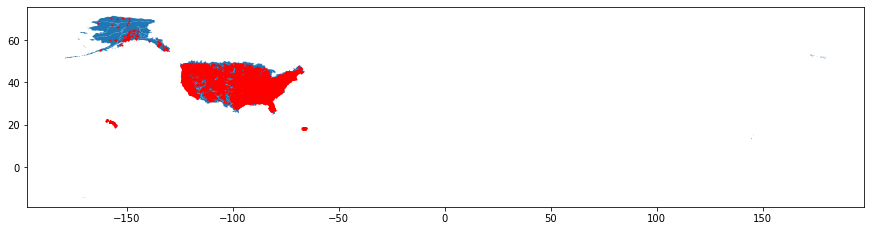

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(15,8))

# Plot population grid
polys.plot(ax=ax)

# Plot points
points.plot(ax=ax, color='red', markersize=1)

In [21]:
# Output path
outfp = r"examples_data/gagesII_9322_HUC4.shp"

# Save to disk
# join.to_file(outfp)

本地电脑上导出shpfile的时候proj总是没信息，可能是程序bug，可以卸载重新安装下geopandas等相关软件。

## 例3 裁剪shp

这部分的例子主要参考了：[Clip a spatial vector layer in Python using Shapely & GeoPandas: GIS in Python](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/vector-data-processing/clip-vector-data-in-python-geopandas-shapely/)

首先什么是GIS意义上的clipping，或者cropping。

即给定一个范围，对另一个空间数据，除去其不在这个范围内的部分，即根据边界，一个空间文件被cut了。

什么时候会用到clip呢：需要的数据比自己所需的多，比如有一部分数据在自己的研究范围之外了。
 
接下来看例子，首先导入一批数据。

In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import geopandas as gpd

# Load the box module from shapely to create box objects
from shapely.geometry import box
import earthpy as et
import seaborn as sns

# Ignore warning about missing/empty geometries
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

# Adjust plot font sizes
sns.set(font_scale=1.5)
sns.set_style("white")

# Set working dir & get data
data = et.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

然后接下来看实操。用到的数据有USA的国家边界数据，州边界数据，还有人口聚集区。

In [6]:
# Import all of your data at the top of your notebook to keep things organized.
country_boundary_us_path = os.path.join("data", "spatial-vector-lidar", 
                                        "usa", "usa-boundary-dissolved.shp")
country_boundary_us = gpd.read_file(country_boundary_us_path)

state_boundary_us_path = os.path.join("data", "spatial-vector-lidar", 
                                      "usa", "usa-states-census-2014.shp")
state_boundary_us = gpd.read_file(state_boundary_us_path)

pop_places_path = os.path.join("data", "spatial-vector-lidar", "global", 
                               "ne_110m_populated_places_simple", "ne_110m_populated_places_simple.shp")
pop_places = gpd.read_file(pop_places_path)

# Are the data all in the same crs?
print("country_boundary_us", country_boundary_us.crs)
print("state_boundary_us", state_boundary_us.crs)
print("pop_places", pop_places.crs)

country_boundary_us epsg:4326
state_boundary_us epsg:4326
pop_places epsg:4326


首先，是对点数据的操作，目标是只选择在CONUS上的点。

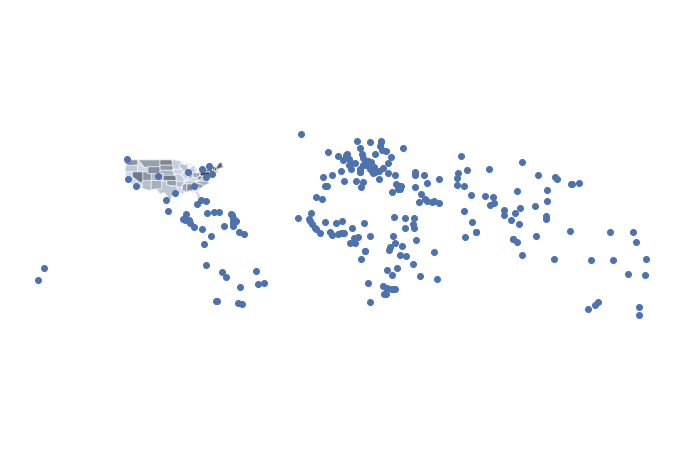

In [3]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_boundary_us.plot(alpha=.5,
                         ax=ax)

state_boundary_us.plot(cmap='Greys',
                       ax=ax,
                       alpha=.5)
pop_places.plot(ax=ax)

plt.axis('equal')
ax.set_axis_off()
plt.show()

clip点数据的一个示例图如下所示：

![](picture/vector-clip.png)

geopandas 以前有一个叫做clip()的函数，能够切割各种类型的shp文件，不过包含的参数较多，因此使用geopandas的intersection()比较多。不过在EarthPy中，有 clip_shp() 函数能自动完成这些事情，现在该函数已经被geopandas收录了，称为包的一部分了，就有了新的clip函数。

clip函数有三个参数：

- gdf: 要被clip的矢量图
- mask: 作为clip的mask
- keep_geom_type: 如果为 True, 仅返回 geometries of original type in case of intersection resulting in multiple geometry types or GeometryCollections. 如果 False, return all resulting geometries (potentially mixed-types). Default value is False (You don’t need to worry about this argument for this assignment)

如果有很多polygon，clip会根据边界clip所有的polygons。

In [4]:
# Clip the data using GeoPandas clip
points_clip = gpd.clip(pop_places, country_boundary_us)

# View the first 6 rows and a few select columns
points_clip[['name', 'geometry', 'scalerank', 'natscale', ]].head()

,name,geometry,scalerank,natscale
175,San Francisco,POINT (-122.41717 37.76920),1,300
176,Denver,POINT (-104.98596 39.74113),1,300
177,Houston,POINT (-95.34193 29.82192),1,300
178,Miami,POINT (-80.22605 25.78956),1,300
179,Atlanta,POINT (-84.40190 33.83196),1,300


上面已经完成了clip，现在可视化一下切割后的结果。

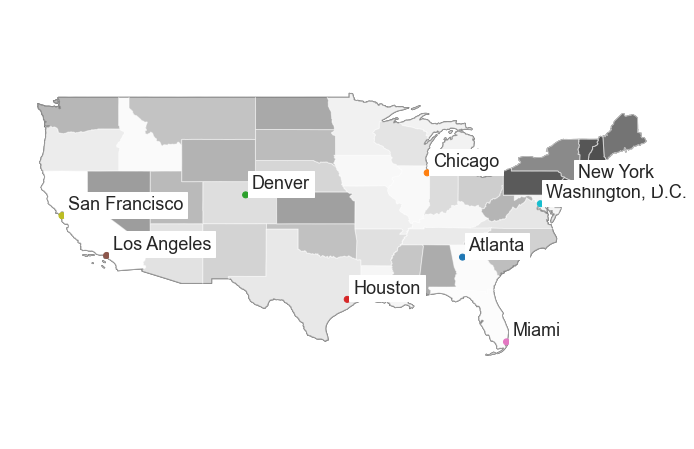

In [5]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_boundary_us.plot(alpha=1,
                         color="white",
                         edgecolor="black",
                         ax=ax)

state_boundary_us.plot(cmap='Greys',
                       ax=ax,
                       alpha=.5)

points_clip.plot(ax=ax,
                 column='name')
ax.set_axis_off()
plt.axis('equal')

# Label each point - note this is just shown here optionally but is not required for your homework
points_clip.apply(lambda x: ax.annotate(s=x['name'],
                                        xy=x.geometry.coords[0],
                                        xytext=(6, 6), textcoords="offset points",
                                        backgroundcolor="white"),
                  axis=1)
plt.show()

下面看clip line或者polygon，要完成这件事，需要以下内容：

1. 确保polygon和line和mask在同一个坐标系下
2. Identify what features in the lines layer fall WITHIN the boundary of the polygon layer
3. Subset the features within the geometry and reset the geometry of the newly clipped layer to be equal to the clipped data.

先导入数据

In [14]:
# Open the roads layer
ne_roads_path = os.path.join("data", "spatial-vector-lidar", "global", 
                             "ne_10m_roads", "ne_10m_roads.shp")
ne_roads = gpd.read_file(ne_roads_path)

# Are both layers in the same CRS?
if (ne_roads.crs == country_boundary_us.crs):
    print("Both layers are in the same crs!",
          ne_roads.crs, country_boundary_us.crs)

Both layers are in the same crs! epsg:4326 epsg:4326


接下来就进行clip，现在又了一个roads的layer，和一个美国边界图。

In [15]:
# Simplify the geometry of the clip extent for faster processing
# Use this with caution as it modifies your data.
country_boundary_us_sim = country_boundary_us.simplify(
    .2, preserve_topology=True)

In [16]:
# Clip data
ne_roads_clip = gpd.clip(ne_roads, country_boundary_us_sim)

# Ignore missing/empty geometries
# ne_roads_clip = ne_roads_clip[~ne_roads_clip.is_empty]

print("The clipped data have fewer line objects (represented by rows):",
      ne_roads_clip.shape, ne_roads.shape)

The clipped data have fewer line objects (represented by rows): (7346, 32) (56601, 32)


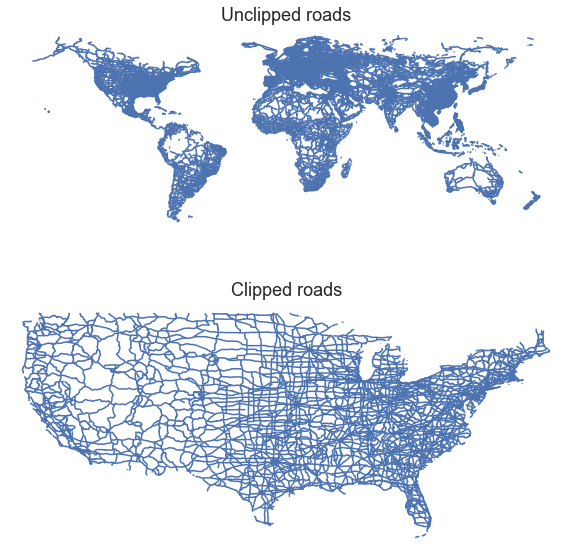

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ne_roads.plot(ax=ax1)
ne_roads_clip.plot(ax=ax2)

ax1.set_title("Unclipped roads")
ax2.set_title("Clipped roads")

ax1.set_axis_off()
ax2.set_axis_off()

plt.axis('equal')
plt.show()

注意clip的数据是没边界的，那么接下来把边界加上

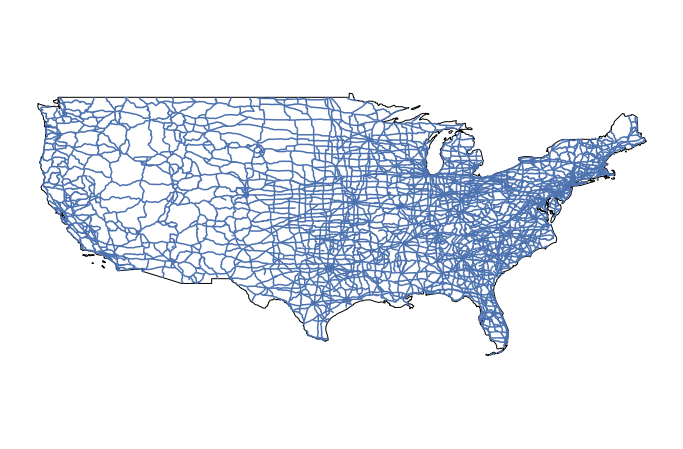

In [18]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_boundary_us.plot(alpha=1,
                         color="white",
                         edgecolor="black",
                         ax=ax)

ne_roads_clip.plot(ax=ax)

ax.set_axis_off()
plt.axis('equal')
plt.show()

接下来，看一个面的实例，用ecoregion的shp文件，主要要先去官网下载：https://www.epa.gov/eco-research/ecoregions-north-america ，然后为了使用方便，手动放到和前面shp文件同样的主目录下去。

In [21]:
# Open the roads layer
na_ecoregion_path = os.path.join("data", "spatial-vector-lidar", "na_cec_eco_l2", 
                             "NA_CEC_Eco_Level2.shp")
na_ecoregion = gpd.read_file(na_ecoregion_path)

# Are both layers in the same CRS?
if (na_ecoregion.crs == country_boundary_us.crs):
    print("Both layers are in the same crs!",
          na_ecoregion.crs, country_boundary_us.crs)
else:
    na_ecoregion = na_ecoregion.to_crs(country_boundary_us.crs)
    print("new proj", na_ecoregion.crs, country_boundary_us.crs)

new proj epsg:4326 epsg:4326


In [22]:
# Clip data
na_ecoregion_clip = gpd.clip(na_ecoregion, country_boundary_us)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

na_ecoregion.plot(ax=ax1)
na_ecoregion_clip.plot(ax=ax2)

ax1.set_title("Unclipped ecoregions")
ax2.set_title("Clipped ecoregions")

ax1.set_axis_off()
ax2.set_axis_off()

plt.axis('equal')
plt.show()

TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -76.443918115046415 43.887130214985092 at -76.443918115046415 43.887130214985092


TopologicalError: The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x000002986CAFA0C8>

不知道为什么，面对 ecoregion 的shapefile，geopandas的clip函数是会报错的，所以换一个，用HUC02的shapefile再试试，数据可以在这里下载：https://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Hydrography/WBD/HU2/



## 例4 空间分散度

有时候需要计算一定区域内点的分布情况来了解这些点带来的影响，比如一个流域内水库的分布情况会不会对径流产生影响。这里简单补充一些关于点分布离散模式计算的方法并给出一些代码。

首先最简单的肯定是类似于标准差的概念，即各个点的位置距离中心点的位置减去均值的平方，求和，再开方。

例子参考：[Point Pattern Analysis](https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html)，顺便补充一些基本概念。

点是可以以两种根本不同的方式理解的空间实体。

一方面，点可以看作是空间中的固定对象，也就是说，它们的位置是给定的（外生的）。在这种解释中，观察点的位置被认为是在该点观察到的值的次要属性。可以将其视为测量穿过给定路口的汽车数量；该位置是固定的，并且感兴趣的数据来自该位置进行的测量。

另一方面，也可以将在某个点上发生的观察视为来自潜在的地理连续过程的测量点。在这种情况下，理论上可以在任何地方进行测量，但只能在某些位置进行。比如测量鸟类翅膀的长度：测量鸟类的位置反映了鸟类运动和觅食的潜在地理过程，而鸟类翅膀的长度可能反映了因鸟类而异的潜在生态过程。这种方法意味着位置和测量都很重要。

当点被视为可以在多个位置发生但仅在其中几个位置发生的事件时，此类事件的集合称为点模式。在这种情况下，点的位置是需要分析的关键方面之一。带有点标记的照片就是一个很好的例子，它在技术上可以在很多地方出现，但我们通常发现照片往往只集中在少数几个点。

点模式分析试图理解并解释产生观测数据的过程。该领域的常见问题包括：

- 模式是什么样的？
- 点分布的本质是什么？
- 位置在空间上的排列方式是否有任何结构？也就是说，事件是否被聚集？还是分散了？
- 为什么事件在那些地方发生而不在其他地方发生？

这些是点模式分析中最常见的问题，尝试通过观察的模式来理解形成这种模式背后的规律。

In [4]:
import pandas as pd
db = pd.read_csv('data/tokyo/tokyo_clean.csv')
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               10000 non-null  object 
 1   longitude             10000 non-null  float64
 2   latitude              10000 non-null  float64
 3   date_taken            10000 non-null  object 
 4   photo/video_page_url  10000 non-null  object 
 5   x                     10000 non-null  float64
 6   y                     10000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 547.0+ KB


衡量离散度 Dispersion 的常见方式是 standard distance。

In [6]:
from pointpats import centrography

In [8]:
centrography.std_distance(db[['x','y']])

8778.218564382098

即平方来说，点距离他们的中心有多远。